# What are all the things/skills you want to demonstrate?

Langauges
- Python - Pandas, Yahoo Finance, Numpy, XBOOST, CVXOP (Convex Optimizer), etc.

# Part 1 - Basic Ideas (Demonstrate Basic Ideas - with S&P500, AAPL, and BTC)

- (1) Sharpe Ratios, Alpha, and Beta by Regression, SR ~ T-Stat and IR ~ Alpha T-Stats (+ Proof)
- (2) Fundamental Law of Active Management: SR Total = SR (per bet) * sqrt(N) (+Proof)
  - also Law of Diversification
- (3) Purification
- (4) Demonstrating - Breadth, Weight by Vol, ect. (Simple Empirical Proof)
  - VolWeights, SRWeights, GeneralWeights, and Practical Weights (Full Proof)
- (5) Two Frameworks: Strategy Space vs. Stock Space (why Strategy is better view)
- (6) Discuss types of Quant Firms

*Later do this in Python+Colab/EEL and Check in Excel

In [1]:
# (0) Download Data
from google.colab import data_table
data_table.disable_dataframe_formatter()

import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

start_date = "2018-09-01"
end_date = "2021-09-01"
univ = ['BTC-USD','AAPL', '^GSPC']
stock_px = yf.download(univ, start=start_date, end=end_date)
stock_px.to_pickle('yf_BTC_APPL_^GSPC.pk')

[*********************100%%**********************]  3 of 3 completed


In [2]:
# (1) S&P, AAPL, BTC Graph - Shrape Ratios, Correlation, and Alpha and Beta

# # Plots
# stock_px['Adj Close']['BTC-USD'].plot()
# plt.title('BTC-USD - Adj Close')
# plt.show()
# stock_px['Adj Close']['AAPL'].plot()
# plt.title('AAPL - Adj Close')
# plt.show()
# stock_px['Adj Close']['^GSPC'].plot()
# plt.title('^GSPC - Adj Close')
# plt.show()

returns = stock_px['Adj Close'].shift(-1, axis = 0) - stock_px['Adj Close']
normalized_returns = returns / returns.mean()
# normalized_returns['BTC-USD'].plot()
# normalized_returns['AAPL'].plot()
# normalized_returns['^GSPC'].plot()
# plt.title('BTC-USD, AAPL, ^GSPC - Normalized Stock Returns')
# plt.show()

# plt.title('BTC-USD')
# stock_px['Adj Close']['BTC-USD'].plot()
# plt.show()
# normalized_returns['BTC-USD'].plot()
# plt.show()

# Sharpe Ratios
print("Avg Daily Returns from", start_date, "to", end_date)
print(returns.mean(),"\n")
sharpes = (returns.mean() / returns.std()) * np.sqrt(len(returns))
print("Sharpes from", start_date, "to", end_date)
print(sharpes,"\n")

print("Avg Daily Normalized Returns from", start_date, "to", end_date)
print(normalized_returns.mean(),"\n")
normalized_sharpes = (normalized_returns.mean() / normalized_returns.std()) * np.sqrt(len(normalized_returns))
print("Sharpes of Normalized from", start_date, "to", end_date)
print(normalized_sharpes,"\n")
print("Should be equivalent to non-Normalized Sharpes")


# Correlations
corrs = returns.corr()
print("Correlations from", start_date, "to", end_date)
print(corrs)

# Alpha and Betas
# -- Regress each onto each other (STRAT2 = B * STRAT1 + error) and then Alpha_STRAT2 = STRAT2 - B * STRAT1
def regress_alpha(strat1_returns, strat2_returns, params_key):
  X = strat1_returns
  X = sm.add_constant(X)
  X = X.dropna()
  Y = strat2_returns.dropna()
  results = sm.OLS(Y, X).fit()
  fitted_strat2 = results.params[params_key]*X[params_key] + results.params['const'] + results.resid
  prediction = results.params[params_key]*X[params_key] + results.params['const']
  beta_contr = results.params[params_key]
  beta_strat_returns = results.params[params_key]*X[params_key]
  alpha_contr = results.params['const']
  alpha_pval = results.pvalues['const']
  alpha_strat_returns = results.resid + results.params['const']
  resid = results.resid
  return alpha_contr, beta_contr, resid, alpha_strat_returns, beta_strat_returns, alpha_pval

def get_alpha(strat1_returns, strat2_returns, title):
  print()
  print(title)
  alpha_contr, beta_contr, resid, alpha_strat_returns, beta_strat_returns, alpha_pval = regress_alpha(strat1_returns, strat2_returns, '^GSPC') # get alpha of strat2
  alpha_sharpe = (alpha_strat_returns.mean() / alpha_strat_returns.std()) * np.sqrt(len(alpha_strat_returns))
  print()
  print("Alpha:", alpha_contr)
  print("Alpha Sharpe / Information Ratio:", alpha_sharpe)
  print("Alpha pval:", alpha_pval)
  print("Beta:", beta_contr)

  print("Corr(alpha, strat1) should be 0:", alpha_strat_returns.corr(strat1_returns))
  print("Corr(beta, strat1) should be 1:", beta_strat_returns.corr(strat1_returns))
  print("Sum of residuals should be 0:", sum(resid))

get_alpha(returns['^GSPC'], returns['AAPL'], title = "Compute Alpha of AAPL from ^GSPC")

daily_returns = returns['^GSPC'].resample('D').asfreq().fillna(0) # Add missing daily return data
daily_returns_btc = returns['BTC-USD'].resample('D').asfreq().fillna(0)
get_alpha(daily_returns, daily_returns_btc, title = "Compute Alpha of BTC-USD from ^GSPC")


Avg Daily Returns from 2018-09-01 to 2021-09-01
AAPL        0.080980
BTC-USD    36.505422
^GSPC       2.343928
dtype: float64 

Sharpes from 2018-09-01 to 2021-09-01
AAPL       1.507535
BTC-USD    1.252366
^GSPC      1.932608
dtype: float64 

Avg Daily Normalized Returns from 2018-09-01 to 2021-09-01
AAPL       1.0
BTC-USD    1.0
^GSPC      1.0
dtype: float64 

Sharpes of Normalized from 2018-09-01 to 2021-09-01
AAPL       1.507535
BTC-USD    1.252366
^GSPC      1.932608
dtype: float64 

Should be equivalent to non-Normalized Sharpes
Correlations from 2018-09-01 to 2021-09-01
             AAPL   BTC-USD     ^GSPC
AAPL     1.000000  0.125018  0.703907
BTC-USD  0.125018  1.000000  0.182629
^GSPC    0.703907  0.182629  1.000000

Compute Alpha of AAPL from ^GSPC

Alpha: 0.007904948507409533
Alpha Sharpe / Information Ratio: 0.15175163390158355
Alpha pval: 0.8797405300711617
Beta: 0.031176442090067296
Corr(alpha, strat1) should be 0: 6.644483926815018e-16
Corr(beta, strat1) should be 1: 1.0

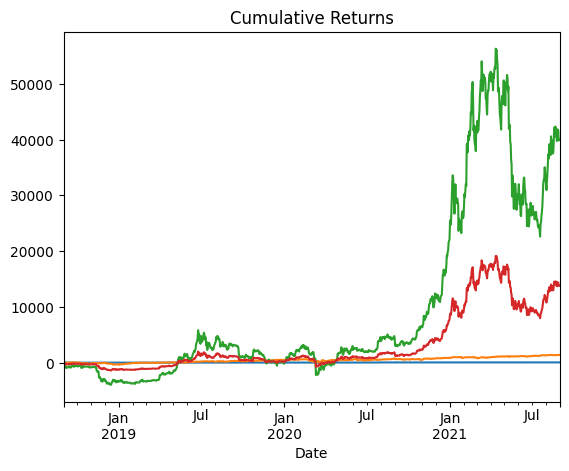

Avg Daily Returns from 2018-09-01 to 2021-09-01
AAPL        0.043446
BTC-USD    36.472115
^GSPC       1.257509
dtype: float64 

Sharpes from 2018-09-01 to 2021-09-01
AAPL       1.104112
BTC-USD    1.251795
^GSPC      1.414996
dtype: float64 

Sharpe of Mixed Strategy (1/3 each): 1.2900114101723812 

Check if correlations basically zero for alphas
Corr(Alpha BTC, ^GSPC): 6.813708900791106e-17
Corr(Alpha AAPL, ^GSPC): 3.81561686345998e-18
Corr(Alpha AAPL, Alpha BTC): -0.0038648007856529262



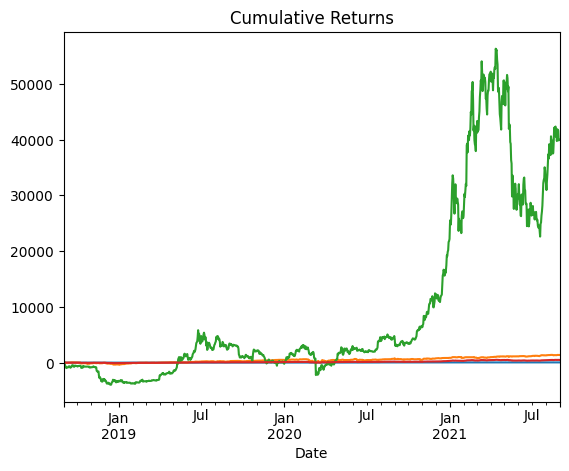

Returns from 2018-09-01 to 2021-09-01
AAPL        0.043446
BTC-USD    36.472115
^GSPC       1.257509
dtype: float64 

Sharpes from 2018-09-01 to 2021-09-01
AAPL       1.104112
BTC-USD    1.251795
^GSPC      1.414996
dtype: float64 

Sharpe of Mixed Strategy (Optimal Portfolio) 1.774767593089046 



In [3]:
# (2) Combinded Portfolios - Fundamental Law of Active Management

daily_returns = returns.resample('D').asfreq().fillna(0)
daily_returns['AAPL'].cumsum().plot()
daily_returns['^GSPC'].cumsum().plot()
daily_returns['BTC-USD'].cumsum().plot()
mix_strat = (1/3) * daily_returns['AAPL'] + (1/3) * daily_returns['^GSPC'] + (1/3) * daily_returns['BTC-USD']
mix_strat.cumsum().plot()
plt.title('Cumulative Returns')
plt.show()

# Sharpe Ratios
print("Avg Daily Returns from", start_date, "to", end_date)
print(daily_returns.mean(),"\n")
sharpes = (daily_returns.mean() / daily_returns.std()) * np.sqrt(len(daily_returns))
print("Sharpes from", start_date, "to", end_date)
print(sharpes,"\n")
mix_strat_sharpe = (mix_strat.mean() / mix_strat.std()) * np.sqrt(len(mix_strat))
print("Sharpe of Mixed Strategy (1/3 each):", mix_strat_sharpe,"\n")

# Optimal Portfolio
_, beta_contr, _, alpha_strat_returns_aapl, _, _ = regress_alpha(daily_returns['^GSPC'], daily_returns['AAPL'], '^GSPC') # get alpha of strat2
alpha_strat_aapl = daily_returns['AAPL'] - beta_contr * daily_returns['^GSPC']

_, beta_contr, _, alpha_strat_returns_btc, _, _ = regress_alpha(daily_returns['^GSPC'], daily_returns['BTC-USD'], '^GSPC') # get alpha of strat2
alpha_strat_btc = daily_returns['BTC-USD'] - beta_contr * daily_returns['^GSPC']

print("Check if correlations basically zero for alphas")
print("Corr(Alpha BTC, ^GSPC):", alpha_strat_btc.corr(daily_returns['^GSPC']))
print("Corr(Alpha AAPL, ^GSPC):", alpha_strat_aapl.corr(daily_returns['^GSPC']))
print("Corr(Alpha AAPL, Alpha BTC):", alpha_strat_aapl.corr(alpha_strat_btc))
print()

# Optimal portfolio weighting to maximize sharpe is SR/std if uncorrleated
# (3) Purification
alpha_strat_btc_sharpe = (alpha_strat_btc.mean() / alpha_strat_btc.std()) * np.sqrt(len(alpha_strat_btc))
alpha_strat_aapl_sharpe = (alpha_strat_aapl.mean() / alpha_strat_aapl.std()) * np.sqrt(len(alpha_strat_aapl))
daily_returns_sharpe = (daily_returns['^GSPC'].mean() / daily_returns['^GSPC'].std()) * np.sqrt(len(daily_returns['^GSPC']))

# (4) Todo Demonstrate - Breadth, Weight by Vol, ect. (Simple Empirical Proof)
# -- VolWeights, SRWeights, GeneralWeights, and Practical Weights (Full Proof)
w1 = alpha_strat_btc_sharpe / alpha_strat_btc.std()
w2 = alpha_strat_aapl_sharpe / alpha_strat_aapl.std()
w3 = daily_returns_sharpe / daily_returns['^GSPC'].std()
factor = 1.0 / (w1 + w2 + w3)

daily_returns['AAPL'].cumsum().plot()
daily_returns['^GSPC'].cumsum().plot()
daily_returns['BTC-USD'].cumsum().plot()
mix_strat = (w1 * factor) * alpha_strat_btc + (w2 * factor) * alpha_strat_aapl + (w3 * factor) * daily_returns['^GSPC']
mix_strat.cumsum().plot()
plt.title('Cumulative Returns')
plt.show()

# Sharpe Ratios
print("Returns from", start_date, "to", end_date)
print(daily_returns.mean(),"\n")
sharpes = (daily_returns.mean() / daily_returns.std()) * np.sqrt(len(daily_returns))
print("Sharpes from", start_date, "to", end_date)
print(sharpes,"\n")
mix_strat_sharpe = (mix_strat.mean() / mix_strat.std()) * np.sqrt(len(mix_strat))
print("Sharpe of Mixed Strategy (Optimal Portfolio)", mix_strat_sharpe,"\n")

# (5) Two Frameworks: Strategy Space vs. Stock Space (why Strategy is better view)
# This shows you can also diversify your stragegies (for lower variance) not just diversifying your stocks
# And there are more strategies than stocks :)

# (6) Discuss types of Quant Firms:
# if you imagine a chart of SR (Sharpe Ratio) per Bet vs. Number of Bets
# (SR/Bet)
# ^
# | Insider Trading
# |
# |     Fundemental Investing
# |
# |                                 Quant
# |          Index Investing
# |
# --------------------------------------------> (Number of Bets)
#
# The main categories of firms are:
# - High Frequency Trading Firms (HFTs)
# - Proprietary Trading Firms (Prop Shops)
# - Hedge Funds
#    - Centralized
#    - Multi Manager
#    - Fundamental
#    - Other
# - Asset Managers
#    - Alternative
#    - Passive
# - Banks

# HFTs, Prop Shops, and Hedge Funds are the “Active” managers. These firms are trying to generate “alpha”.
# - Fairly cutthroat with longer hours
# - Fixed base salary and a bonus is directly linked to fund performance and/or your contribution to that performance
# - Very meritocratic, “eat what you kill” environment and they care less about fancy titles / hierarchy
# Asset Managers [Passive] want to simply track the market or indices, and Asset Managers [Alternative] are somewhere in between.
# - More relaxed, with better work-life balance
# - Your compensation is mostly a fixed salary with less link to firm performance
# - About gaining promotions, managing bigger teams, and politics
# - Alternatives are again somewhere in between on all dimensions
# Banks do a bit of everything.
# Further more firms are further split into two categories:
# (1) “Big Names” which people typically know
# (2) And “Other Players” who are less known but still recruit
# Firms in (2) are not “worse” than firms in (1)
# - It depends on the specific role/team/group
# - But brand names are good for first time roles

In [4]:
### Part 2 - Types of Strategies (Outline the Info-Landscape, Form, and 4-Box Diagram of Strategies)

# Information Landscape of Strategies (As the list goes it gets [Higher Turnover, Lower Capacity, Higher Sharpe, More Data])
# (1) Fundamentals
# (2) Sentiment
# (3) Event-Driven
# (4) Price/Volume

# Forms of Strategies:
# (XS) Cross Sectional
# (TS) Time Series
# (TS+XS) Time Series, Cross Sectional

# Typesof Strategies:
# (VB) Value Based (Trading on Value)
# -- Income Based Measures (E/P, S/P, Operating Cash Flow/P)
# -- Metrics with Enterprise Value (EBIT/EV, EBITDA/EV, Gross Profit/EV)
# -- Dividend Yield
# -- Combo
# -- Portfolio Construction via Signal Transforms:
# ----- Raw
# ----- Dollar Neutral
# ----- Normalize (Winsore and Truncate)
# ----- Rank, Rank Threshold, and Inverse CDF
# (~VB) Not Value Based (Trading on Behavior)
# -- Sentiment, Events, Price/Volume
# (M) Momentum (New Information)
# -- Time Horizon
# -- New Information/Activity
# ----- PEADs and PFRDs
# -- Seasonality
# -- Investment Themes
# -- Technical Plays
# (R) Reversion (Absence of New Information - Uninformed Trading)
# -- Time Horizon
# -- Uninformed Trading
# -- Correlation
# ----- Pairs Trading
# -- Macro Environment
# ----- VIX and Reversal Returns

# Ken-French Baselines
# -- HML aka Fama-French (Book-to-Price - S&P500 of Value Strategies)
# -- UMD (Up  Minus Down - S&P500 of Momentum Strategies)
# -- STREV (Short Term Reversal - S&P500 of Reversal Strategies)
# -- Show all correlation

# TODO Project Ken-French Baselines but for Crypto
# Note: Value Based and Momentum tend to be Negatively Correlated, and can be combined for better Sharpe
# -- Step 1: Define CC10 (Top Ten Crypto Currencies Weighted by Market Cap)
# -- Step 2: Defive VIX-CC10
# -- Step 3: Define and find Sharpe of:
# ----- HML aka Fama-French (Book-to-Price - S&P500 of Value Strategies) (~0.35 Sharpe)
# ----- UMD (Up  Minus Down - S&P500 of Momentum Strategies) (~0.5 Sharpe)
# ----- STREV (Short Term Reversal - S&P500 of Reversal Strategies) (~1.43 Share)
# ----- Show all correlation
# -- Step 4: Optimize a Portfolio with Convex Optimizer
# ----- (Mentally) Test VolWeights, SRWeights, GeneralWeights, and Practical Weights
# -- Step 5: Run Unconstrained Backtests
# -- Step 6: Other Performance Metrics
# -- Step 7: Run Constrained Backtests on Best Portfolio with Managed Risk
# -- Live Trade
# Do part of this in Python+EEL and Expert Excel for Checking

In [5]:
# (1) Define CC10 (Ten Well Known Crypto Currencies Weighted by Market Cap)
start_date = "2020-10-01"
end_date = "2021-10-01"

# tickers
tickers = ["BTC-USD",
"ETH-USD",
"AVAX-USD",
"ADA-USD",
"XRP-USD",
"DOGE-USD",
"ALGO-USD",
"LTC-USD",
"BCH-USD",
"XLM-USD"]
# Get the data for this tickers from yahoo finance
data = yf.download(tickers, start_date, end_date)
weighting = [float(yf.Ticker(ticker).info["marketCap"]) for ticker in tickers]
weighting = list(np.array(weighting) / sum(weighting))

cc10 = sum([data['Adj Close'][ticker] * weighting[i] for i, ticker in enumerate(tickers)])

[*********************100%%**********************]  10 of 10 completed


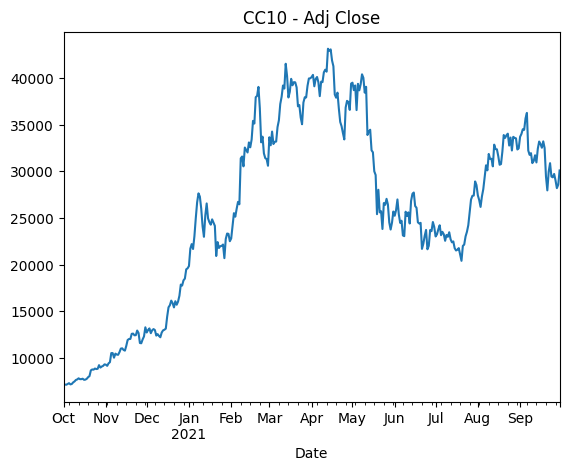

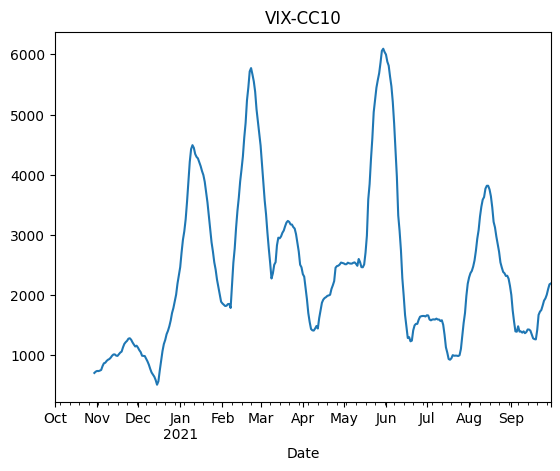

In [6]:
# (2) Defive VIX-CC10
# Plots
cc10.plot()
plt.title('CC10 - Adj Close')
plt.show()
# VIX-CC10
vix_cc10 = cc10.rolling(window=30).std()
vix_cc10.plot()
plt.title('VIX-CC10')
plt.show()

In [97]:
# BTC Cost per Transaction: https://data.nasdaq.com/data/BCHAIN/CPTRA-bitcoin-cost-per-transaction
# BTC Transaction Volume: https://data.nasdaq.com/data/BCHAIN/ETRVU-bitcoin-estimated-transaction-volume-usd
# BTC MarketCap Volume: https://data.nasdaq.com/data/BCHAIN/MKTCP-bitcoin-market-capitalization
btc_cptra = pd.read_csv("/content/BCHAIN-CPTRA.csv")
btc_etrvu = pd.read_csv("/content/BCHAIN-ETRVU.csv")
btc_mktcp = pd.read_csv("/content/BCHAIN-MKTCP.csv")
# NVT Data Came from here: https://blog.ccdata.io/how-to-calculate-nvt-ratios-with-the-cryptocompare-api-870d6d6b3c86
nvt = pd.read_csv("/content/nvt_data.csv")
nvt['time'] = pd.to_datetime(nvt['time'], unit='s')
nvt.rename(columns = {'time': 'Date',
                      'BTC': 'BTC-USD',
                      'ETH': 'ETH-USD',
                      'ADA': 'ADA-USD',
                      'DOGE': 'DOGE-USD',
                      'LTC': 'LTC-USD',
                      'BCH': 'BCH-USD'}, inplace = True)
nvt = nvt.set_index('Date')

In [122]:
# (3) Step 3: Define and find Sharpe of:
# ----- HML aka Fama-French (Book-to-Price - S&P500 of Value Strategies) (~0.35 Sharpe)
# High Minus Low
# As a proxy for Book-to-Price for cypto we are using Network Value-to-Transactions (NVT) Ratio
# NVT is calculated by dividing the Network Value (market cap) by the USD volume transmitted
# We only have NVT data for these coins:
nvt_list = ["BTC-USD",
            "ETH-USD",
            "ADA-USD",
            "DOGE-USD",
            "LTC-USD",
            "BCH-USD"]
data_for_nvt = data['Adj Close'].filter(nvt_list)
returns = data_for_nvt.shift(-1, axis = 0) - data_for_nvt
high_signal = nvt.apply(lambda row: 1 * (row == row.min()), axis=1)
low_signal = nvt.apply(lambda row: -1 *(row == row.max()), axis=1)
hml_signal = high_signal + low_signal
hml_signal = hml_signal.loc[returns.index.min():returns.index.max()]
hml_returns_segmented = pd.DataFrame(returns.values*hml_signal.values, columns=returns.columns, index=returns.index)
hml_returns = sum([hml_returns_segmented[ticker] * weighting[i] for i, ticker in enumerate(nvt_list)])
# Unweighted by MarketCap
#hml_returns = pd.DataFrame(returns.values*hml_signal.values, columns=returns.columns, index=returns.index).sum(axis=1)

# ----- UMD (Up  Minus Down - S&P500 of Momentum Strategies) (~0.5 Sharpe)
# Up Minus Down
returns = data['Adj Close'].shift(-1, axis = 0) - data['Adj Close']
period = 30
up_signal = 1 * (returns.rolling(period).mean() > 0)
down_signal = -1 * (returns.rolling(period).mean() < 0)
umd_signal = up_signal + down_signal
umd_returns = sum([returns[ticker] * umd_signal[ticker] for ticker in tickers])

# ----- STREV (Short Term Reversal - S&P500 of Reversal Strategies) (~1.43 Share)
# Short Term Reversal
returns = data['Adj Close'].shift(-1, axis = 0) - data['Adj Close']
period = 90
combined_high_signal = - (1/2) * (returns.rolling(period).mean() - returns.rolling(period).std() > 0)
combined_low_signal = (1/2) * (returns.rolling(period).mean() - returns.rolling(period).std() < 0)
strev_signal = combined_low_signal + combined_high_signal
strev_returns = sum([returns[ticker] * strev_signal[ticker] for ticker in tickers])

print("###")

# ----- Show all Sharpes and Correlations
# Sharpes
print()
print("Avg Daily Returns from", start_date, "to", end_date)
print("HML:", hml_returns.mean())
print("UMD:", umd_returns.mean())
print("STREV:", strev_returns.mean())

hml_sharpe = (hml_returns.mean() / hml_returns.std()) * np.sqrt(len(hml_returns))
umd_sharpe = (umd_returns.mean() / umd_returns.std()) * np.sqrt(len(umd_returns))
strev_sharpe = (strev_returns.mean() / strev_returns.std()) * np.sqrt(len(strev_returns))
print()
print("Sharpes from", start_date, "to", end_date)
print("Sharpe HML:", hml_sharpe.mean())
print("Sharpe UMD:", umd_sharpe.mean())
print("Sharpe STREV:", strev_sharpe.mean())

print()
print("Strategy Correlations")
print("Corr(HML, UMD):", hml_returns.corr(umd_returns))
print("Corr(HML, STREV):", hml_returns.corr(strev_returns))
print("Corr(UMD, STREV):", umd_returns.corr(strev_returns))
print()

###

Avg Daily Returns from 2020-10-01 to 2021-10-01
HML: 4.45481431548897
UMD: 346.56774290947175
STREV: 26.016831927833014

Sharpes from 2020-10-01 to 2021-10-01
Sharpe HML: 0.20248140441528512
Sharpe UMD: 3.8696038495883367
Sharpe STREV: 0.5465277818392098

Strategy Correlations
Corr(HML, UMD): 0.20641518073417336
Corr(HML, STREV): -0.3485936338749743
Corr(UMD, STREV): 0.08309746678642727



In [ ]:
!pip install cvxpy

In [136]:
# (4) Optimize a Portfolio with Convex Optimizer (Only Last/Next Step)
import cvxpy as cvx
from sklearn.covariance import LedoitWolf

# Example CC10 Index with

# compute returns
ret = data['Adj Close'].shift(-1, axis = 0) - data['Adj Close']
ret = ret.iloc[1:]
# generate ideal portfolio to rebalance to
d = {"BTC-USD": weighting[0],
  "ETH-USD": weighting[1],
  "AVAX-USD": weighting[2],
  "ADA-USD": weighting[3],
  "XRP-USD": weighting[4],
  "DOGE-USD": weighting[5],
  "ALGO-USD": weighting[6],
  "LTC-USD": weighting[7],
  "BCH-USD": weighting[8],
  "XLM-USD": weighting[9]}
ideal = pd.Series(data=d, index=d.keys())
# approximate prior portfolio
d = {"BTC-USD": 0,
  "ETH-USD": 0,
  "AVAX-USD": 0,
  "ADA-USD": 0,
  "XRP-USD": 0,
  "DOGE-USD": 0,
  "ALGO-USD": 0,
  "LTC-USD": 0,
  "BCH-USD": 0,
  "XLM-USD": 0}
w_prev = pd.Series(data=d, index=d.keys())

# generate sigma
sigma_hist = ret.cov() # don't use this w/ large n
# shrinkage (http://www.ledoit.net/honey.pdf)
sigma_lw = LedoitWolf().fit(ret.fillna(0).values).covariance_

# generate target weights variable
w = cvx.Variable(ret.shape[1])
print("w shape:", w.shape)

def get_tracking_error(w,ideal,sigma):
    param = cvx.Parameter(shape=sigma.shape, value=sigma, PSD=True)
    tracking_error = cvx.quad_form(w,param) - 2 * ideal @ sigma @ w  - ideal @ sigma @ ideal
    return tracking_error

tracking_error = get_tracking_error(w,ideal,sigma_lw)
print("Tracking Error (Should be Convex):", tracking_error.curvature)

# solve tracking error problem
objective = cvx.Minimize(tracking_error)
prob = cvx.Problem(objective)
prob.solve()
w_track = pd.Series(w.value,index=ideal.index)

# diff from ideal
print("Difference from w_track to ideal (Should be close to zero):", (w_track - ideal).abs().sum())

# tcost term
def get_tcost(w,w_prev,comm_bps=1e-4,tc_penalty=1/100.): # only includes commissions
    tcost = tc_penalty*cvx.sum(cvx.abs(w - w_prev)*comm_bps)
    return tcost

tcost = get_tcost(w,w_prev)
print("Tcost (Should be Convex):", tcost.curvature)

# tcost objective
objective_tc = cvx.Minimize(tracking_error + tcost)

# solve problem with tc
prob = cvx.Problem(objective_tc)
prob.solve()
w_tc = pd.Series(w.value,index=ideal.index)

# nonzero weight diff vs. ideal
print("Difference from w_tc to ideal (Should be greater than zero):", (w_tc - ideal).abs().sum())

# new turnover
to_tc = (w_tc - w_prev).abs().sum()
print("Turnover (Optimized for Tracking and Transaction Cost):", to_tc)

# old turnover
to_track = (w_track - w_prev).abs().sum()
print("Turnover (Optimized for just Tracking):", to_track)

# not fully invested anymore
print("Weight Sum (not Fully Invested):", w_tc.sum())

# not long-only anymore
print("Min Weight (not Long Only):", w_tc.min())

# fully invested constraint
constraints = []
fully_invested = cvx.sum(w) == 1
constraints.append(fully_invested)

# long only constraint
long_only = w >= 0
constraints.append(long_only)

prob = cvx.Problem(objective_tc,constraints)
prob.solve()
w_cons = pd.Series(w.value,index=ideal.index)

# fully invested
print("Weight Sum (Fully Invested):", w_cons.sum())

# long-only (w/ rounding error)
print("Min Weight (Long Only):", w_cons.min())

w shape: (10,)
Tracking Error (Should be Convex): CONVEX
Difference from w_track to ideal (Should be close to zero): 1.6555767173853653e-16
Tcost (Should be Convex): CONVEX
Difference from w_tc to ideal (Should be greater than zero): 2.9011635658813574e-06
Turnover (Optimized for Tracking and Transaction Cost): 1.0000029011635658
Turnover (Optimized for just Tracking): 1.0000000000000002
Weight Sum (not Fully Invested): 1.0000029011635658
Min Weight (not Long Only): 0.0009764266959427204
Weight Sum (Fully Invested): 1.0000000013606145
Min Weight (Long Only): 0.0009762238360825943


/usr/local/lib/python3.10/dist-packages/cvxpy/reductions/solvers/solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


In [ ]:
# (5) Run Unconstrained Backtests (Code Unavailable)

In [ ]:
# (6) Other Performance Metrics (See Slides)

In [ ]:
# (7) Run Constrained Backtests on Best Portfolio with Managed Risk (Code Unavailable)
# -- Live Trade

In [ ]:
### Part 3 - Backtesting - Notes (Code Unavailable)

# Portfolio Beta

# Unoptimized Backtest

# Transaction Costs: Tcost = Commissions + Bid-Ask Spread + Slippage
# How to find each:
# -- Measuring Slippage
# -- Using it (Turnover * Tcost for Unconstrained Backtest)

# Optimized Backtest (What is added)

# Other Performance Metrics: Hit Rate, Slugging Ratio, Calmer Ratio, Soritino Ratio, Value at Risk (%), Skew, and Kurtosis
# --- Discuss when each should be used

In [ ]:
### Part 4 - Execution - Notes (Code Unavailable)

# Improving Execution
# -- Slow Down Signal
# -- Volatility/Volume
# -- Explotited Short-Term Signal
# -- Model Slippage
# -- Optimization

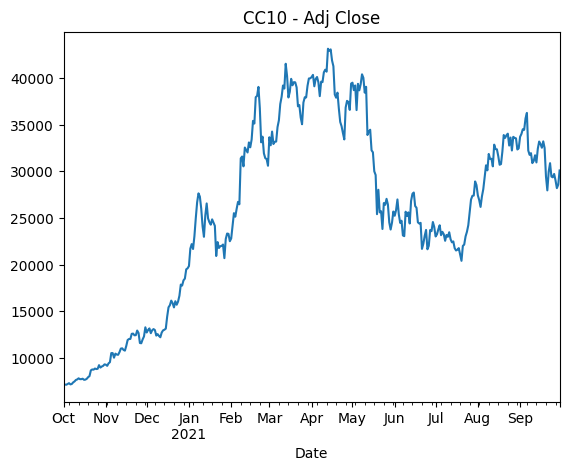

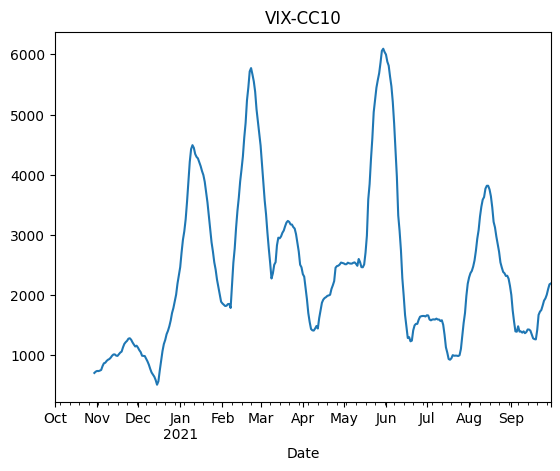

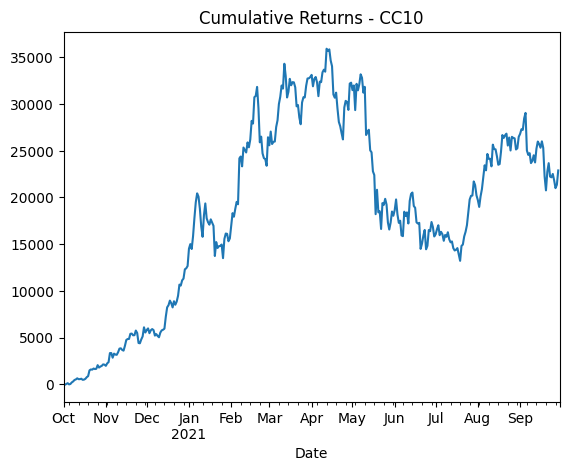

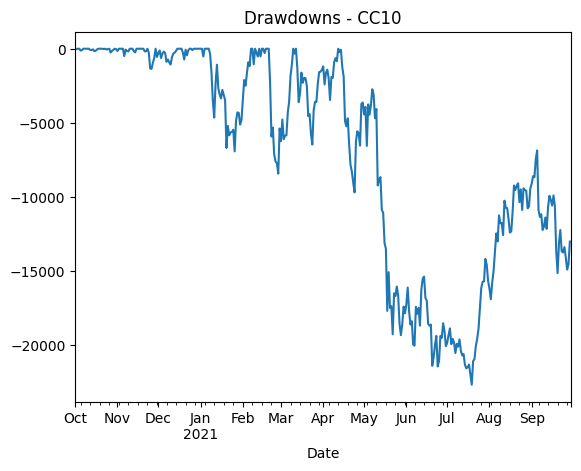

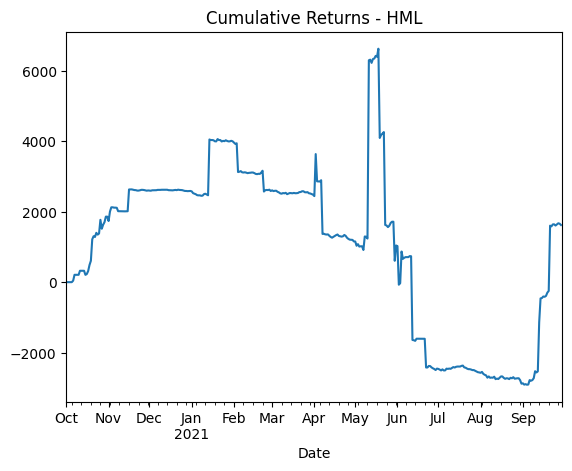

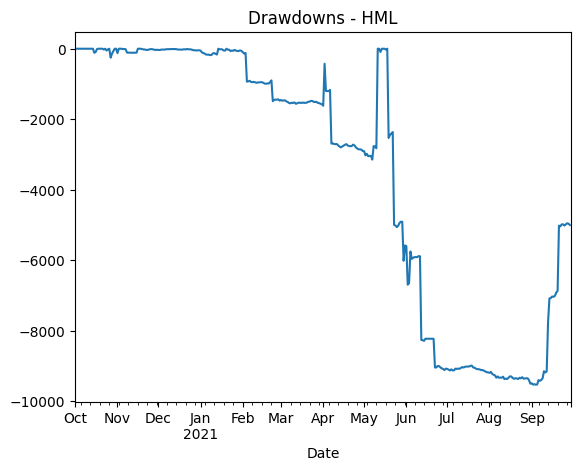

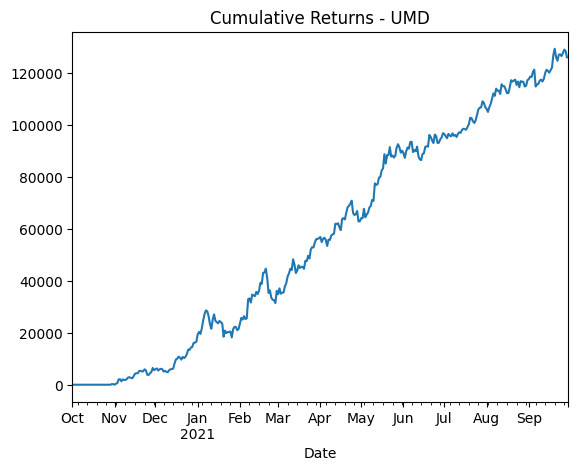

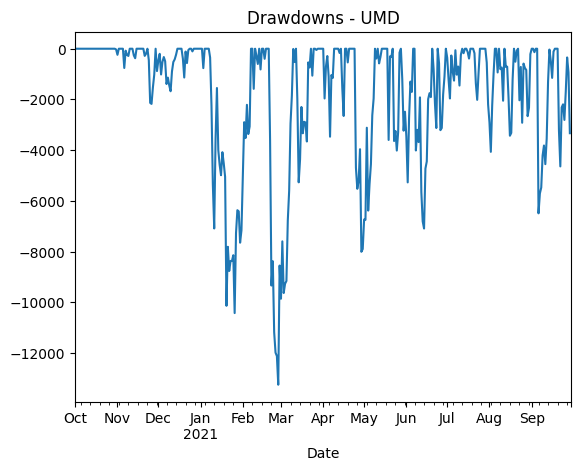

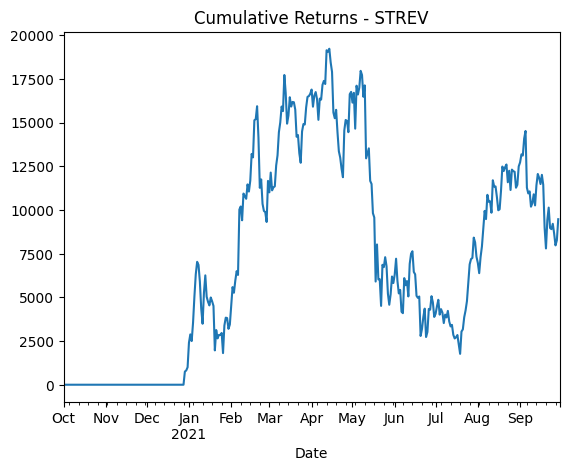

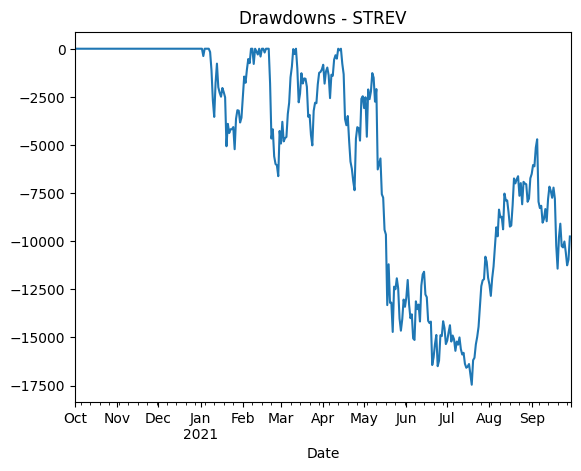

In [139]:
### Part 5 - Risk Management - Notes (Code Unavailable)
# Drawdown

# Plots
cc10.plot()
plt.title('CC10 - Adj Close')
plt.show()
# VIX-CC10
vix_cc10 = cc10.rolling(window=30).std()
vix_cc10.plot()
plt.title('VIX-CC10')
plt.show()
# Drawdown
def compute_drawdowns(returns, title):
  print()
  cumulative = returns.cumsum().round(2)
  highvalue = cumulative.cummax()

  drawdown = cumulative - highvalue
  cumulative.plot()
  plt.title("Cumulative Returns - " + title)
  plt.show()
  drawdown.plot()
  plt.title("Drawdowns - " + title)
  plt.show()

returns = cc10.shift(-1, axis = 0) - cc10
compute_drawdowns(returns, title="CC10")

# Our Portfolio
compute_drawdowns(hml_returns, title="HML")
compute_drawdowns(umd_returns, title="UMD")
compute_drawdowns(strev_returns, title="STREV")